# LTFS Data Science FinHack 3 Solution

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !pip install --upgrade --no-cache-dir catboost
# !pip install --upgrade --no-cache-dir seaborn
# !pip install --upgrade --no-cache-dir tabulate
# !pip install --upgrade --no-cache-dir featuretools
# !pip install --upgrade --no-cache-dir xgboost
# !pip install --upgrade --no-cache-dir lightgbm
# !pip install --upgrade --no-cache-dir tqdm
# !pip install --upgrade --no-cache-dir psutil
# !pip install --upgrade --no-cache-dir openpyxl
# !pip install --upgrade --no-cache-dir scikit-learn
# !pip install --upgrade --no-cache-dir pydot2
# !pip install --upgrade --no-cache-dir category-encoders
# !pip install --upgrade --no-cache-dir jupyter
# !pip install --upgrade --no-cache-dir pandas
# !pip install --upgrade --no-cache-dir tensorflow-gpu
# !pip install --upgrade --no-cache-dir pydot
# !pip install --upgrade --no-cache-dir pydot2

In [3]:
import os
import re
import glob
import time
import psutil
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.notebook import tqdm
tqdm.pandas()

import featuretools as ft

from pathlib import Path
from datetime import datetime
from tabulate import tabulate
from collections import Counter
from collections import namedtuple

from category_encoders import OrdinalEncoder

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.impute import SimpleImputer, MissingIndicator

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Lambda, Flatten, Dropout, Input, Activation, Concatenate, concatenate, Bidirectional, LSTM, Convolution1D, BatchNormalization
from tensorflow.keras.layers import Reshape, Input, Embedding, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Nadam
from tensorflow.keras.utils import to_categorical, plot_model, model_to_dot
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mean_squared_error, logcosh, mean_absolute_percentage_error

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18408919460573108686
]


In [5]:
def get_embedding_size(n_cat: int) -> int:
    """
    Determines the embedding vector size for number of categories
    https://github.com/fastai/fastai/blob/96c5927648ecf83f0bc9ab601f672d3c0ffe0059/fastai/tabular/data.py#L13
    :param n_cat: number of categories
    :return: int
    """
    return int(min(600, round(1.6 * n_cat ** 0.56)))

def get_embeddings(categorical_map: list):
    """
    Generates embedding layers using categorical mappings
    :param categorical_map: list, [(column_name, num_of_categories), ....]
    :return: list, list
    """
    embedding_inputs = []
    embedding_outputs = []
    for column_name, nb_unique_classes in categorical_map:
        assert (nb_unique_classes > 1), f"{column_name} column has nb_unique_classes <= 1"
        embedding_size = get_embedding_size(nb_unique_classes)

        # One Embedding Layer for each categorical variable
        model_input = Input(shape=(1,))
        model_output = Embedding(nb_unique_classes, embedding_size)(model_input)
        model_output = Reshape(target_shape=(embedding_size,))(model_output)

        embedding_inputs.append(model_input)
        embedding_outputs.append(model_output)

    return embedding_inputs, embedding_outputs

def get_categorical_inputs_for_dl(x_arr):
    """
    https://machinelearningmastery.com/howprepare_categorical_inputs_test-to-prepare-categorical-data-for-deep-learning-in-python/
    :param x_arr: numpy array of categorical data of shape (n_samples, n_columns)
    :return: list
    """
    return [x_arr[:, i] for i in range(x_arr.shape[1])]

def plot_countplot(series_):
    """
    https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count
    :param series_:
    :return:
    """
    sns.set_style("whitegrid", {'axes.grid': False})
    headers = [series_.name, 'Count', 'Percentage']
    value_counts = series_.value_counts()
    value_counts_norm = series_.value_counts(normalize=True)
    table = [[
        v, value_counts[v], round(value_counts_norm[v], 3)
    ] for v in value_counts.index]
    print(tabulate(table, headers, tablefmt="psql"))
    sns.countplot(y=series_, orient='horizontal', order=value_counts.index)

def date_to_integer(dt_time):
    """
    https://github.com/SudalaiRajkumar/ML/blob/master/AV_LordOfTheMachines/Explorations.ipynb
    """
    try:
        return time.mktime(dt_time.timetuple())
    except ValueError:
        return np.nan

def run_LGB(params, train, test, feature_names, n_folds=10, seed=0, return_models=False):
    """
    https://stackoverflow.com/questions/56303572/how-can-i-solve-this-unknown-label-type-error
    """
    skf = GroupKFold(n_splits=n_folds) # shuffle=True, random_state=seed
    X, y, groups = train[feature_names], train['Top-up Month'].values.astype('int'), train['ID'].values.astype('int')

    num_classes = np.unique(y).size
    preds = np.zeros((test.shape[0], params['num_classes']))

    models = list()
    for i, (train_index, test_index) in enumerate(skf.split(X, y, groups)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val, reference=dtrain)

        bst = lgb.train(
            params=params,
            train_set=dtrain,
            valid_sets=[dtrain, dval],
            valid_names=['train', 'eval'],
            num_boost_round=30_000,
            verbose_eval=100,
            early_stopping_rounds=100
        )

        score_, iter_ = bst.best_score['eval']['multi_logloss'], bst.best_iteration
        test_preds = bst.predict(test[feature_names], num_iteration=iter_)
        preds += test_preds
        models.append(bst)
        
    if return_models:
        return preds / n_folds, models
    return preds / n_folds

def run_XGB(params, train, test, feature_names, n_folds = 10, seed = 0, return_models=False):
    skf = GroupKFold(n_splits=n_folds)
    X, y, groups = train[feature_names], train['Top-up Month'].values.astype('int'), train['ID'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['num_class']))
    
    models = list()
    for i, (train_index, test_index) in enumerate(skf.split(X, y, groups)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = xgb.DMatrix(data=X_train, label=y_train, missing=np.nan)
        dval = xgb.DMatrix(data = X_val, label=y_val, missing=np.nan)

        bst = xgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 100,
                evals                 = [(dtrain, 'train'), (dval, 'eval')],
                verbose_eval          = 100
            )

        score_, iter_ = bst.best_score, bst.best_iteration
        test_preds = bst.predict(xgb.DMatrix(test[feature_names]))
        preds += test_preds
        models.append(bst)
        
    if return_models:
        return preds / n_folds, models
    return preds / n_folds

def run_CGB(params, train, test, feature_names, n_folds = 10, seed=0, cat_cols=None, return_models=False):
    skf = GroupKFold(n_splits=n_folds)
    X, y, groups = train[feature_names], train['Top-up Month'].values.astype('int'), train['ID'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['classes_count']))
    
    models = list()
    for i, (train_index, test_index) in enumerate(skf.split(X, y, groups)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = cgb.Pool(data=X_train, label=y_train, cat_features=cat_cols)
        dval = cgb.Pool(data=X_val, label=y_val, cat_features=cat_cols)
        
        bst = cgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 100,
                evals                 = [dval],
                verbose_eval          = 100
            )

        score_, iter_ = bst.get_best_score(), bst.get_best_iteration()
        test_preds = bst.predict(cgb.Pool(test[feature_names], cat_features=cat_cols))
        preds += test_preds
        models.append(bst)
        
    if return_models:
        return preds / n_folds, models
    return preds / n_folds

def get_dual_features(df, feature_tuple, op = "ratio"):
    if op not in ("ratio", "difference", "multiply"):
        raise ValueError("`op` must be one of `ratio` or `difference` or `multiply`")
        
    feature_dict = {}
    for pair in feature_tuple:
        feature_name, f1, f2 = pair
        
        if np.logical_or(f1 not in df.columns, f2 not in df.columns):
            raise ValueError(f"either of {f1}/{f2} not found...")
        
        if op == 'ratio':
            ratio = df[f1] / df[f2] if op == 'ratio' else df[f1] - df[f2]
        elif op == 'difference':
            ratio = df[f1] - df[f2]
        else:
            ratio = df[f1] * df[f2]
            
        feature_dict[feature_name] = ratio.values
    return pd.DataFrame(feature_dict)

def plot_feature_importance(importance, names, model_type):
    """
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    """
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(12, 30))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:100], y=fi_df['feature_names'][:100])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [6]:
DEFAULT_CATEGORICAL_FILL = 'NOT_AVAILABLE'
print(f"Using {psutil.cpu_count()} CPU Cores...")

IN_COLAB = False
path = 'storage'
if IN_COLAB:
    path = '/content/drive/MyDrive/Colab Notebooks'

Using 8 CPU Cores...


In [5]:
df_train_data = pd.read_pickle(f'{path}/train_Data.pkl')   
df_train_bureau = pd.read_pickle(f'{path}/train_bureau.pkl')  
df_test_data = pd.read_pickle(f'{path}/test_Data.pkl')  
df_test_bureau = pd.read_pickle(f'{path}/test_bureau.pkl')  

In [6]:
# (128655, 26) (560844, 25) (14745, 25) (64019, 25)
print(df_train_data.shape, df_train_bureau.shape, df_test_data.shape, df_test_bureau.shape)

(128655, 26) (560844, 25) (14745, 25) (64019, 25)


In [7]:
df_train_bureau['source'] = 'train'
df_test_bureau['source'] = 'test'

In [8]:
df = pd.concat([df_train_data, df_test_data], axis=0)
df_bureau = pd.concat([df_train_bureau, df_test_bureau], axis=0)

df.reset_index(drop=True, inplace=True)
df_bureau.reset_index(drop=True, inplace=True)
df = df_bureau.merge(df, how='left', on='ID')

In [9]:
df.shape

(624863, 51)

In [23]:
print("performing to_datetime...")
source_dt_cols = ['DisbursalDate', 'MaturityDAte', 'AuthDate']
source_dt_cols_seq = ['CLOSE-DT', 'DISBURSED-DT', 'DATE-REPORTED', 'LAST-PAYMENT-DATE']

for col in source_dt_cols + source_dt_cols_seq:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df.loc[df['MaturityDAte'].isnull(), 'MaturityDAte'] = df['DisbursalDate'] + (df['MaturityDAte'] - df['DisbursalDate']).median()

print("performing cleaning...")    
df.loc[df['ASSET_CLASS'].isin(['1', '01']), 'ASSET_CLASS'] = 'Standard'
df.loc[df['ASSET_CLASS'] == '2', 'ASSET_CLASS'] = 'SubStandard'

df['DISBURSED-AMT/HIGH CREDIT'] = df['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '').astype(float)
df['CURRENT-BAL'] = df['CURRENT-BAL'].str.replace(',', '').astype(float)
df['OVERDUE-AMT'] = df['OVERDUE-AMT'].str.replace(',', '').astype(float)
df['CREDIT-LIMIT/SANC AMT']= df['CREDIT-LIMIT/SANC AMT'].str.replace(',', '').astype(float)

df['City'] = df['City'] +'-'+ df['State']

print('filling categoricals before featuretools...')

source_con_cols = ['Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'LTV', 'AGE', 'MonthlyIncome']
source_con_cols_seq = ['TENURE', 'DISBURSED-AMT/HIGH CREDIT', 'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT']

source_cat_cols = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode', 'BranchID', 'Area', 
                   'ManufacturerID', 'SupplierID', 'SEX', 'City', 'State', 'ZiPCODE']
source_cat_cols_seq = ['SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND', 
                       'ACCOUNT-STATUS', 'INSTALLMENT-FREQUENCY', 'ASSET_CLASS']

df[source_cat_cols] = df[source_cat_cols].fillna(DEFAULT_CATEGORICAL_FILL)
df[source_cat_cols_seq] = df[source_cat_cols_seq].fillna(DEFAULT_CATEGORICAL_FILL)

performing to_datetime...
performing cleaning...
filling categoricals before featuretools...


In [24]:
print('performing regex and definitions...')
def strip(value, remove_spaces=False):
    result = re.sub(r"\s+", "" if remove_spaces else " ", value)
    result = result.strip()
    return result

def installment_freq(value):
    result = re.search(r"[a-z]+", str(value).lower())
    if result:
        return strip(result.group(0))
    else:
        return np.nan
    
def installment_amt(value):
    result = re.search(r"[\d,]+", str(value).lower())
    if result:
        return strip(result.group(0))
    else:
        return np.nan
    
df['p_cat_seq_INSTALLMENT_FREQ'] = df['INSTALLMENT-AMT'].map(installment_freq)
df['INSTALLMENT_AMT_CLEAN'] = df['INSTALLMENT-AMT'].map(installment_amt).str.replace(',', '').astype(float)
df['ACTIVE_INSTALLMENT_AMT'] = df[['ACCOUNT-STATUS', 'INSTALLMENT_AMT_CLEAN']].apply(lambda r: r[1] if r[0] == 'Active' else 0., axis=1)

def active_installment_amt_monthly(r):
    if r[1] == 'biweekly':
        return r[0] * 2
    elif r[1] == 'weekly':
        return r[0] * 4
    elif r[1] == 'quarterly':
        return r[0] / 3   
    elif r[1] == 'annually':
        return r[0] / 12
    elif r[1] == 'bimonthly':
        return r[0] / 2
    elif r[1] == 'semi':
        return r[0] / 6
    else:
        return r[0]
    
df['p_con_seq_ACTIVE_MONTHLY_INSTALLMENT_AMT'] = df[['ACTIVE_INSTALLMENT_AMT', 'p_cat_seq_INSTALLMENT_FREQ']].apply(active_installment_amt_monthly, axis=1)
df['p_con_seq_MONTHLY_INSTALLMENT_AMT'] = df[['ACTIVE_INSTALLMENT_AMT', 'p_cat_seq_INSTALLMENT_FREQ']].apply(active_installment_amt_monthly, axis=1)

performing regex and definitions...


In [25]:
print('correcting EMI...')

def func(args):
    total_repayment = args[0] * args[1]
    if total_repayment < args[2]:
        return args[0] * 10.
    return args[0]

df['EMI'] = df[['EMI', 'Tenure', 'DisbursalAmount']].apply(func, axis=1)

print("extracting dual features...")

ratio_features_list = [
    ('p_ra_con_DisbursalAmt_AssetCost', 'DisbursalAmount', 'AssetCost'),
    ('p_ra_con_AssetCost_MonthlyInc', 'AssetCost', 'MonthlyIncome'),
    ('p_ra_con_EMI_MonthlyInc', 'EMI', 'MonthlyIncome'),
    ('p_ra_con_seq_ACTIVE_MONTHLY_INSMT_AMT_MonthlyInc', 'p_con_seq_ACTIVE_MONTHLY_INSTALLMENT_AMT', 'MonthlyIncome')
]

ratio_features = get_dual_features(df, ratio_features_list)

multiply_features_list = [
    ('p_mu_con_EMI_Tenure', 'EMI', 'Tenure'),
]
multiply_features = get_dual_features(df, multiply_features_list, 'multiply')
df = pd.concat([df, ratio_features, multiply_features], axis=1)

difference_features_list = [
    ('p_di_con_AssetCost_DisbursalAmt', 'AssetCost', 'DisbursalAmount'),
    ('p_di_con_AmtFinance_DisbursalAmt', 'AmountFinance', 'DisbursalAmount'),
    ('p_di_con_AssetCost_AmtFinance', 'AssetCost', 'AmountFinance'),
    ('p_di_con_Totalrepayment_AssetCost', 'p_mu_con_EMI_Tenure', 'AssetCost'),
    ('p_di_con_seq_TT', 'Tenure', 'TENURE'),
]
difference_features = get_dual_features(df, difference_features_list, 'difference')
df = pd.concat([df, difference_features], axis=1)

print('extracting more features...')

df['p_con_REPAYMENT_RATIO'] = df[['EMI', 'Tenure', 'DisbursalAmount']].apply(lambda args: (args[0] * args[1]) / args[2], axis=1)
df['p_cat_seq_IS_NEW_LOAN'] = (df['DISBURSED-DT'] > df['DisbursalDate']).map(int)
df['p_con_seq_NB_DAYS_SINCE_LTFS'] = (df['DISBURSED-DT'] - df['DisbursalDate'].shift(1)) / np.timedelta64(1, 'D')

df['p_con_LOAN_TENURE'] = (df['MaturityDAte'] - df['DisbursalDate']).dt.days
df['p_con_AGE_OF_PERSON_AT_MATURITY'] = df['AGE'] + (df['Tenure'] / 12)

del ratio_features, multiply_features, difference_features

correcting EMI...
extracting dual features...
extracting more features...


In [26]:
# import decimal

# # create a new context for this task
# ctx = decimal.Context()
# # 20 digits should be enough for everyone :D
# ctx.prec = 108

# def float_to_str(f):
#     """
#     Convert the given float to a string, without resorting to scientific notation
#     https://stackoverflow.com/questions/38847690/convert-float-to-string-in-positional-format-without-scientific-notation-and-fa
#     """
#     d1 = ctx.create_decimal(repr(f))
#     return format(d1, 'f')

# def dpd_hist(args):
#     dpd_str = str(args[0]).lower()[:18]
    
#     if 'e+' in dpd_str:
#         dpd_str = float_to_str(float(dpd_str))[:18]

#     lst = [float(dp) for dp in list(map(''.join, zip(*[iter(re.sub("xxx|ddd", "000", dpd_str))]*3)))]
#     return pd.Series(lst, dtype='float')

# file_path = f'{path}/df_dpd_hst.pkl'
# if os.path.isfile(file_path):
#     df_dpd_hst = pd.read_pickle(file_path)
# else:
#     df_dpd_hst = df[['DPD - HIST']].apply(dpd_hist, axis=1)
#     df_dpd_hst.to_pickle(file_path)
    
# df_dpd_hst.columns = [f"p_con_DPD_{i}" for i in range(df_dpd_hst.columns.__len__())]
# df = df.merge(df_dpd_hst, left_index=True, right_index=True, how='inner', suffixes=('_suffix', None))
# df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [27]:
# def bal_hist(args):
#     cur_bal_str = str(args[0]).lower()
#     try:
#         if cur_bal_str == 'nan':
#             cur_bal_str = '0'

#         lst = [float(0. if c.strip() == '' else c) / (args[1] + 1e-8) for c in cur_bal_str.rstrip(',').split(",")[:6]]
#     except ValueError:
#         print(cur_bal_str)
#     return pd.Series(lst, dtype='float')

# file_path = f'{path}/df_cur_bal_hst.pkl'
# if os.path.isfile(file_path):
#     df_grp = pd.read_pickle(file_path)
# else:
#     df_grp = df[['CUR BAL - HIST', 'DISBURSED-AMT/HIGH CREDIT']].apply(bal_hist, axis=1)
#     df_grp.to_pickle(file_path)

# df_grp.columns = [f"p_con_CUR_BAL_{i}" for i in range(df_grp.columns.__len__())]
# df = df.merge(df_grp, left_index=True, right_index=True, how='inner', suffixes=('_suffix', None))
# df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [28]:
# file_path = f'{path}/df_amt_ovr_hst.pkl'
# if os.path.isfile(file_path):
#     df_grp = pd.read_pickle(file_path)
# else:
#     df_grp = df[['AMT OVERDUE - HIST', 'DISBURSED-AMT/HIGH CREDIT']].apply(bal_hist, axis=1)
#     df_grp.to_pickle(file_path)

# df_grp.columns = [f"p_con_AMT_OVR_{i}" for i in range(df_grp.columns.__len__())]
# df = df.merge(df_grp, left_index=True, right_index=True, how='inner', suffixes=('_suffix', None))
# df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [29]:
# file_path = f'{path}/df_amt_paid_hst.pkl'
# if os.path.isfile(file_path):
#     df_grp = pd.read_pickle(file_path)
# else:
#     df_grp = df[['AMT PAID - HIST', 'DISBURSED-AMT/HIGH CREDIT']].apply(bal_hist, axis=1)
#     df_grp.to_pickle(file_path)

# df_grp.columns = [f"p_con_AMT_PAID_{i}" for i in range(df_grp.columns.__len__())]
# df = df.merge(df_grp, left_index=True, right_index=True, how='inner', suffixes=('_suffix', None))
# df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [30]:
print('categorical binning...')
df['LTV_BINS'] = df['LTV'].map(int)
df['AGE_BINS'] = df['AGE'].fillna(0).map(int)

categorical binning...


In [31]:
print('categorical pairing...')
df['ACCT_CONTRIBUTOR_ID'] = df['ACCT-TYPE'].map(str) + df['CONTRIBUTOR-TYPE'].map(str)
df['ACCT_OWNERSHIP_ID'] = df['ACCT-TYPE'].map(str) + df['OWNERSHIP-IND'].map(str)
df['CONTRIBUTOR_OWNERSHIP_ID'] = df['CONTRIBUTOR-TYPE'].map(str) + df['OWNERSHIP-IND'].map(str)

categorical pairing...


In [32]:
print('binary target binning...')
df['F_NO_TOP_UP'] = df['Top-up Month'].map(lambda t: 1 if t == 'No Top-up Service' else 0)
df['F_48_MONTHS'] = df['Top-up Month'].map(lambda t: 1 if t == ' > 48 Months' else 0)
df['F_24_30_MONTHS'] = df['Top-up Month'].map(lambda t: 1 if t == '24-30 Months' else 0)
df['F_12_18_MONTHS'] = df['Top-up Month'].map(lambda t: 1 if t == '12-18 Months' else 0)
df['F_18_24_MONTHS'] = df['Top-up Month'].map(lambda t: 1 if t == '18-24 Months' else 0)
df['F_30_36_MONTHS'] = df['Top-up Month'].map(lambda t: 1 if t == '30-36 Months' else 0)
df['F_36_48_MONTHS'] = df['Top-up Month'].map(lambda t: 1 if t == '36-48 Months' else 0)

binary target binning...


In [33]:
print('preparing data for featuretools...')
df['REPORT_ID'] = range(df.__len__())

preparing data for featuretools...


In [34]:
# print('creating certain group features...')
# def func(df):
#     df = df.sort_values('DISBURSED-DT')
    
#     if df['DISBURSED-DT'].isnull().all():
#         df['LOAN_RECUR_FREQ_DAYS'] = np.nan
#     else:
#         df['LOAN_RECUR_FREQ_DAYS'] = (df['DISBURSED-DT'] - df['DISBURSED-DT'].shift(1)) / np.timedelta64(1, 'D')
        
# #     df['MOST_LATEST_PAYMENT_DATE'] = df['LAST-PAYMENT-DATE'].max()
# #     df['MOST_LATEST_DISBURSAL_DATE'] = df['DISBURSED-DT'].max()
    
#     return df

# essential_columns = [
#     'REPORT_ID', 
#     'ID', 
#     'DISBURSED-DT', 
#     'LAST-PAYMENT-DATE',
# ]

# jb = ['REPORT_ID']

# file_path = f'{path}/df_id_groups.pkl'
# if os.path.isfile(file_path):
#     df_grp = pd.read_pickle(file_path)
# else:
#     df_grp = df[essential_columns].groupby('ID').progress_apply(func).reset_index(drop=True)
#     df_grp.to_pickle(file_path)
    
# df = df.merge(df_grp.drop(list(set(essential_columns)^set(jb)), axis=1), on=jb, how='inner', suffixes=('_suffix', None))
# df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [35]:
# print('performing normalization of bureau and others....')
# def func(df):
#     columns_ = [
#         ('p_con_NORM_WRT_LTFS_DISBURSED_AMT', 'DISBURSED-AMT/HIGH CREDIT'),
#     ]
    
#     for cnew, c in columns_:
#         self_value = df[df['SELF-INDICATOR'] == True][c].size 
#         self_value = df[df['SELF-INDICATOR'] == True][c].fillna(0.).iloc[0] if self_value > 0 else 0.
#         df[cnew] = np.nan if df[c].isnull().all() or self_value == 0. else df[df['SELF-INDICATOR'] == False][c].mean() - self_value
        
#     return df

# essential_columns = [
#     'ID',
#     'SELF-INDICATOR',
#     'REPORT_ID',
#     'ACCT-TYPE',
#     'DISBURSED-AMT/HIGH CREDIT',
# ]

# jb = ['REPORT_ID']


# file_path = f'{path}/df_acct_type_groups.pkl'
# if os.path.isfile(file_path):
#     df_grp = pd.read_pickle(file_path)
# else:
#     df_grp = df[essential_columns].groupby(['ID', 'ACCT-TYPE']).progress_apply(func).reset_index(drop=True)
#     df_grp.to_pickle(file_path)
    
# df = df.merge(df_grp.drop(list(set(essential_columns)^set(jb)), axis=1), on=jb, how='left', suffixes=('_suffix', None))
# df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [36]:
print('correcting DISBURSED-AMT/HIGH CREDIT...')
df['DISBURSED-AMT/HIGH CREDIT'] = df[['CREDIT-LIMIT/SANC AMT', 'DISBURSED-AMT/HIGH CREDIT']].apply(lambda args: args[0] if args[0] > args[1] else args[1], axis=1)

correcting DISBURSED-AMT/HIGH CREDIT...


In [37]:
def func(df):
    columns_ = [
        ('p_con_seq_NORM_DISBURSED_AMT', 'DISBURSED-AMT/HIGH CREDIT'),
        ('p_con_seq_NORM_INSTALLMENT_AMT', 'p_con_seq_MONTHLY_INSTALLMENT_AMT'),
        ('p_con_seq_NORM_CURRENT_BAL', 'CURRENT-BAL'),
        ('p_con_seq_NORM_OVERDUE_AMT', 'OVERDUE-AMT'),
    ]
    for cnew, c in columns_:
        df[cnew] = np.nan if df[c].isnull().all() else df[c] - df[c].mean()
        
    return df

essential_columns = [
    'REPORT_ID',
    'ACCT-TYPE',
    'DISBURSED-AMT/HIGH CREDIT', 
    'p_con_seq_MONTHLY_INSTALLMENT_AMT', 
    'CURRENT-BAL', 
    'OVERDUE-AMT',
]

jb = ['REPORT_ID']

file_path = f'{path}/df_groupby_ACCT_TYPE.pkl'
if os.path.isfile(file_path):
    df_grp = pd.read_pickle(file_path)
else:
    df_grp = df[essential_columns].groupby('ACCT-TYPE').progress_apply(func).reset_index(drop=True)
    df_grp.to_pickle(file_path)
    
df = df.merge(df_grp.drop(list(set(essential_columns)^set(jb)), axis=1), on=jb, how='left', suffixes=('_suffix', None))
df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)


def func(df):
    if df['MonthlyIncome'].isnull().all():
        df['p_con_NORM_MonthlyIncome'] = np.nan
    else:
        df['p_con_NORM_MonthlyIncome'] = df['MonthlyIncome'] - df['MonthlyIncome'].mean()
        
    return df

essential_columns = [
    'REPORT_ID',
    'AGE_BINS',
    'MonthlyIncome', 
]

jb = ['REPORT_ID']


file_path = f'{path}/df_groupby_AGE_BINS.pkl'
if os.path.isfile(file_path):
    df_grp = pd.read_pickle(file_path)
else:
    df_grp = df[essential_columns].groupby('AGE_BINS').progress_apply(func).reset_index(drop=True)
    df_grp.to_pickle(file_path)
    
df = df.merge(df_grp.drop(list(set(essential_columns)^set(jb)), axis=1), on=jb, how='left', suffixes=('_suffix', None))
df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

def func(df):
    if df['DisbursalAmount'].isnull().all():
        df['p_con_NORM_DisbursalAmount'] = np.nan
    else:
        df['p_con_NORM_DisbursalAmount'] = df['DisbursalAmount'] - df['DisbursalAmount'].mean()
        
    return df

essential_columns = [
    'REPORT_ID',
    'BranchID',
    'DisbursalAmount', 
]

jb = ['REPORT_ID']


file_path = f'{path}/df_groupby_BranchID.pkl'
if os.path.isfile(file_path):
    df_grp = pd.read_pickle(file_path)
else:
    df_grp = df[essential_columns].groupby('BranchID').progress_apply(func).reset_index(drop=True)
    df_grp.to_pickle(file_path)
    
df = df.merge(df_grp.drop(list(set(essential_columns)^set(jb)), axis=1), on=jb, how='left', suffixes=('_suffix', None))
df.drop([c for c in df.columns if '_suffix' in c], axis=1, inplace=True)

In [38]:
# other_cols = [c for c in df.columns if c not in ['ID'] + source_dt_cols + source_cat_cols]
# df[df['ID'].isin(df['ID'].sample(1000).values)][['ID'] + source_dt_cols + source_cat_cols + other_cols].to_excel('sample.xlsx', index=False)

In [39]:
additional_seq_cols = [c for c in df.columns if '_seq_' in c]
additional_con_seq_cols = [c for c in additional_seq_cols if '_con_' in c and c not in source_con_cols_seq]
additional_cat_seq_cols = [c for c in additional_seq_cols if '_cat_' in c and c not in source_cat_cols_seq]

In [40]:
additional_cat_cols = [c for c in df.columns if '_cat_' in c and c not in additional_seq_cols + source_cat_cols] + ['LTV_BINS', 'AGE_BINS']
additional_con_cols = [c for c in df.columns if '_con_' in c and c not in additional_seq_cols + source_con_cols]

In [41]:
# print('creating temperory date ordinals...') # only for boostings algo's
# for col in ['CLOSE-DT', 'DISBURSED-DT', 'DATE-REPORTED', 'LAST-PAYMENT-DATE']:
#     df[f"temp_{col}"] = df[col].map(date_to_integer)

entering featuretools...


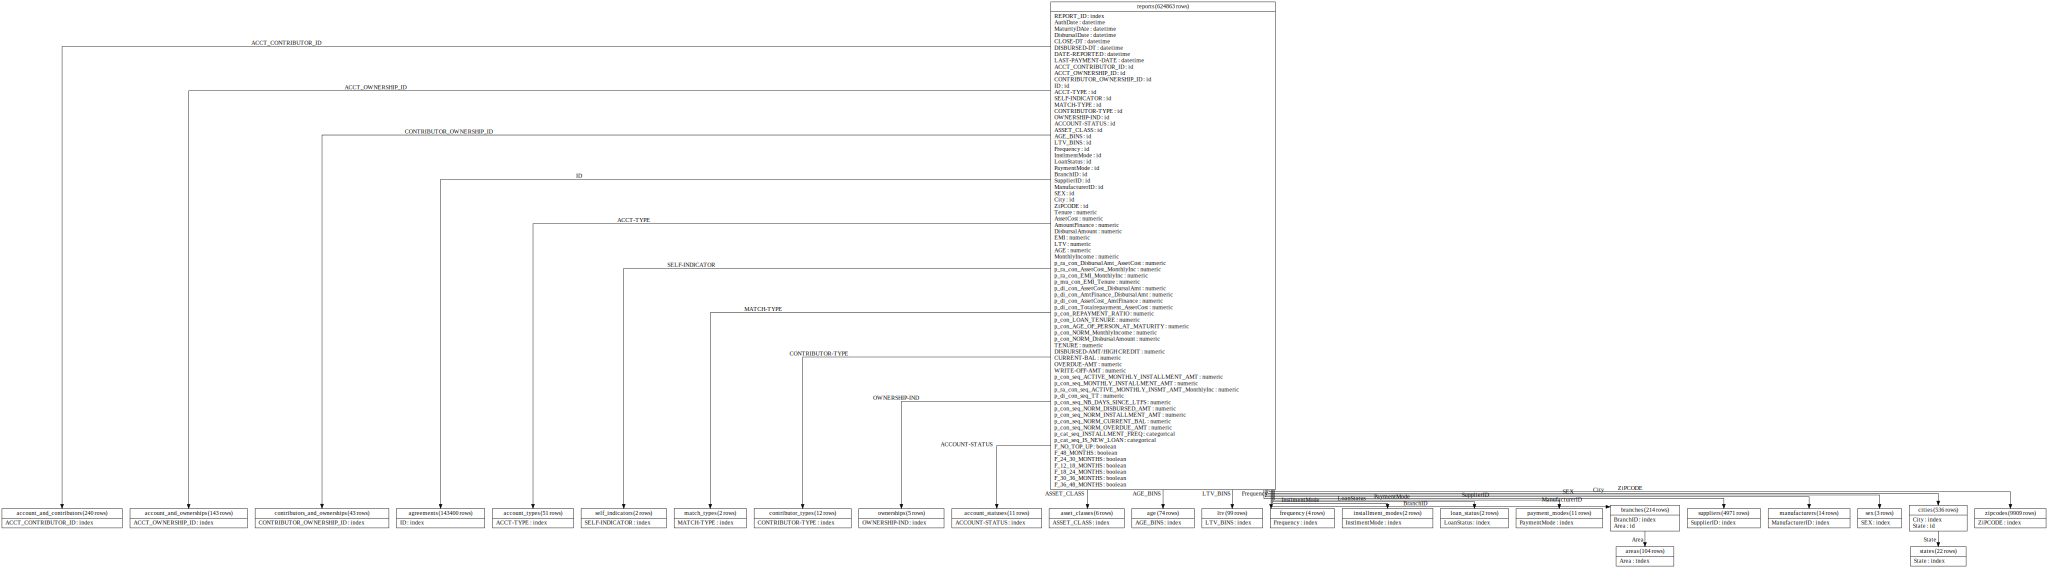

In [42]:
print('entering featuretools...')
df['REPORT_ID'] = df['REPORT_ID'].astype(int)

es = ft.EntitySet()

# entity_id: [entity_index, [entity_variables]]
main_mapping = {
    'account_and_contributors': ['ACCT_CONTRIBUTOR_ID', {
        'ACCT_CONTRIBUTOR_ID': ft.variable_types.Index,
    }],
    'account_and_ownerships': ['ACCT_OWNERSHIP_ID', {
        'ACCT_OWNERSHIP_ID': ft.variable_types.Index,
    }],
    'contributors_and_ownerships': ['CONTRIBUTOR_OWNERSHIP_ID', {
        'CONTRIBUTOR_OWNERSHIP_ID': ft.variable_types.Index,
    }],
    'agreements': ['ID', {
        'ID': ft.variable_types.Index,
    }],
    'account_types': ['ACCT-TYPE', {
        'ACCT-TYPE': ft.variable_types.Index,
    }],
    'self_indicators': ['SELF-INDICATOR', {
        'SELF-INDICATOR': ft.variable_types.Index,
    }],
    'match_types': ['MATCH-TYPE', {
        'MATCH-TYPE': ft.variable_types.Index,
    }],
    'contributor_types': ['CONTRIBUTOR-TYPE', {
        'CONTRIBUTOR-TYPE': ft.variable_types.Index,
    }],
    'ownerships': ['OWNERSHIP-IND', {
        'OWNERSHIP-IND': ft.variable_types.Index,
    }],
    'account_statuses': ['ACCOUNT-STATUS', {
        'ACCOUNT-STATUS': ft.variable_types.Index,
    }],
    'asset_classes': ['ASSET_CLASS', {
        'ASSET_CLASS': ft.variable_types.Index,
    }],
    'age': ['AGE_BINS', {
        'AGE_BINS': ft.variable_types.Index,
    }],
    'ltv': ['LTV_BINS', {
        'LTV_BINS': ft.variable_types.Index,
    }],
    'frequency': ['Frequency', {
        'Frequency': ft.variable_types.Index,
    }],
    'installment_modes': ['InstlmentMode', {
        'InstlmentMode': ft.variable_types.Index,
    }],
    'loan_status': ['LoanStatus', {
        'LoanStatus': ft.variable_types.Index,
    }],
    'payment_modes': ['PaymentMode', {
        'PaymentMode': ft.variable_types.Index,
    }],
    'branches': ['BranchID', {
        'BranchID': ft.variable_types.Index,
        'Area': ft.variable_types.Id,
    }],
    'suppliers': ['SupplierID', {
        'SupplierID': ft.variable_types.Index,
    }],
    'manufacturers': ['ManufacturerID', {
        'ManufacturerID': ft.variable_types.Index,
    }],
    'sex': ['SEX', {
        'SEX': ft.variable_types.Index,
    }],
    'cities': ['City', {
        'City': ft.variable_types.Index,
        'State': ft.variable_types.Id,
    }],
    'zipcodes': ['ZiPCODE', {
        'ZiPCODE': ft.variable_types.Index, # 444511
    }],
}

branches_mapping = {
    'areas': ['Area', {
        'Area': ft.variable_types.Index,
    }],
}

cities_mapping = {
    'states': ['State', {
        'State': ft.variable_types.Index,
    }],
}

main_variables = {
    'REPORT_ID' : ft.variable_types.Index,
    
    'AuthDate': ft.variable_types.Datetime,
    'MaturityDAte': ft.variable_types.Datetime,
    'DisbursalDate': ft.variable_types.Datetime,
    
    'CLOSE-DT': ft.variable_types.Datetime,
    'DISBURSED-DT': ft.variable_types.Datetime,
    'DATE-REPORTED': ft.variable_types.Datetime,
    'LAST-PAYMENT-DATE': ft.variable_types.Datetime,
}


# ==========================================
# Creating Level 2 Entities
# ==========================================
for entity_id, (entity_index, entity_variables) in cities_mapping.items():
    df_index = df.drop_duplicates([entity_index])[list(entity_variables)].reset_index(drop=True)
    es = es.entity_from_dataframe(entity_id=entity_id, dataframe=df_index, index=entity_index, variable_types=entity_variables)

    
for entity_id, (entity_index, entity_variables) in branches_mapping.items():
    df_index = df.drop_duplicates([entity_index])[list(entity_variables)].reset_index(drop=True)
    es = es.entity_from_dataframe(entity_id=entity_id, dataframe=df_index, index=entity_index, variable_types=entity_variables)
    
# ==========================================
# Creating Level 1 Entities
# ==========================================
for entity_id, (entity_index, entity_variables) in main_mapping.items():
    
    df_index = df.drop_duplicates([entity_index])[list(entity_variables)].reset_index(drop=True)
    es = es.entity_from_dataframe(entity_id=entity_id, dataframe=df_index, index=entity_index, variable_types=entity_variables)
    main_variables[entity_index] = ft.variable_types.Id

# ==========================================
# Adding numeric variables
# ==========================================
main_variables['Tenure'] = ft.variable_types.Numeric 
main_variables['AssetCost'] = ft.variable_types.Numeric 
main_variables['AmountFinance'] = ft.variable_types.Numeric 
main_variables['DisbursalAmount'] = ft.variable_types.Numeric 
main_variables['EMI'] = ft.variable_types.Numeric 
main_variables['LTV'] = ft.variable_types.Numeric 
main_variables['AGE'] = ft.variable_types.Numeric 
main_variables['MonthlyIncome'] = ft.variable_types.Numeric 

for c in additional_con_cols:
    main_variables[c] = ft.variable_types.Numeric 

# ['CLOSE-DT', 'DISBURSED-DT', 'DATE-REPORTED', 'LAST-PAYMENT-DATE'] 
for c in source_con_cols_seq + additional_con_seq_cols:
    main_variables[c] = ft.variable_types.Numeric 
    

for c in additional_cat_seq_cols + additional_cat_cols: 
    main_variables[c] = ft.variable_types.Categorical

main_variables['F_NO_TOP_UP'] = ft.variable_types.Boolean
main_variables['F_48_MONTHS'] = ft.variable_types.Boolean
main_variables['F_24_30_MONTHS'] = ft.variable_types.Boolean
main_variables['F_12_18_MONTHS'] = ft.variable_types.Boolean
main_variables['F_18_24_MONTHS'] = ft.variable_types.Boolean
main_variables['F_30_36_MONTHS'] = ft.variable_types.Boolean
main_variables['F_36_48_MONTHS'] = ft.variable_types.Boolean


# ======================
# Adding Main Entity
# ======================
# WARNING: Using only `df_train_dataset` and `df_test_dataset`
es = es.entity_from_dataframe(entity_id="reports", dataframe=df[list(main_variables.keys())].copy(), index="REPORT_ID", variable_types=main_variables)

# ==========================================
# Adding Relationships to Main
# ==========================================
for entity_id, (entity_index, _) in main_mapping.items():
    es = es.add_relationship(ft.Relationship(es[entity_id][entity_index], es["reports"][entity_index]))

# ==========================================
# Adding Relationships to Level 2
# ==========================================
for entity_id, (entity_index, _) in cities_mapping.items():
    es = es.add_relationship(ft.Relationship(es[entity_id][entity_index], es["cities"][entity_index]))  
    
for entity_id, (entity_index, _) in branches_mapping.items():
    es = es.add_relationship(ft.Relationship(es[entity_id][entity_index], es["branches"][entity_index]))  
    
es.plot()

In [43]:
LTFS_LOAN_SPECIFICS_CON = [
    'AGE', 
    'AmountFinance', 
    'AssetCost', 
    'DisbursalAmount', 
    'EMI', 
    'LTV', 
    'MonthlyIncome', 
    'Tenure',
] + additional_con_cols

LTFS_LOAN_SPECIFICS_CAT = source_cat_cols + additional_cat_cols

LTFS_LOAN_SPECIFICS_BOOL = [
    'F_12_18_MONTHS',
    'F_18_24_MONTHS',
    'F_24_30_MONTHS',
    'F_30_36_MONTHS',
    'F_36_48_MONTHS',
    'F_48_MONTHS',
    'F_NO_TOP_UP',
]

BUREAU_LOAN_CAT = [
    'ACCT-TYPE', 
    'SELF-INDICATOR', 
    'MATCH-TYPE', 
    'CONTRIBUTOR-TYPE', 
    'OWNERSHIP-IND', 
    'ACCOUNT-STATUS', 
    'ASSET_CLASS',
    
##  commented as resource expensive
#     'ACCT_CONTRIBUTOR_ID',
#     'ACCT_OWNERSHIP-ID',
#     'CONTRIBUTOR_OWNERSHIP_ID',
] + additional_cat_seq_cols

In [44]:
from featuretools.primitives.standard.aggregation_primitives import NMostCommon
n_most_common = NMostCommon(n=1)

ft_args = namedtuple('ft_args', [
    'entity_name', 
    'target_entity', 
    'target_entity_id',
    'ignore_variables',
    'ignore_entities',
    'agg_primitives',
    'trans_primitives',
    'interesting_values',
    'where_primitives',
    'drop_exact',
    'max_depth',
    'primitive_options',
])


# ['mean', 'std', 'max', 'min', 'num_unique', 'count', 'percent_true']
# https://stackoverflow.com/questions/62193884/use-featuretools-on-specific-columns-only
target_entities = [    
    ft_args('reports_et', 
            target_entity='reports', 
            target_entity_id='REPORT_ID', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=[],
            trans_primitives=[
                'day', 
                'month', 
                'year', 
                'week', 
                'weekday', 
                'is_weekend',
            ],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=list(main_variables.keys()) + [
                'branches.Area',
                'cities.State',
            ],
            max_depth=1,
            primitive_options=None,
            ),
     ft_args('agreements_et', 
            target_entity='agreements', 
            target_entity_id='ID', 
            ignore_variables=None, 
            ignore_entities=[],
            agg_primitives=['count', 'num_unique', n_most_common],
            trans_primitives=[],
            interesting_values=BUREAU_LOAN_CAT,
            where_primitives=['count'],
            drop_exact=[],
            max_depth=2,
            primitive_options={
                ('num_unique', n_most_common): {
                    'ignore_variables': {
                        'reports': [c for c in LTFS_LOAN_SPECIFICS_CAT if c not in ['Area', 'State']],
                        'branches': ['Area'],
                        'cities': ['State'],
                    }
                }
            }
    ),
    ft_args('account_types_et', 
            target_entity='account_types', 
            target_entity_id='ACCT-TYPE', 
            ignore_variables=None, 
            ignore_entities=[],
            agg_primitives=['count', 'percent_true'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('contributor_types_et', 
            target_entity='contributor_types', 
            target_entity_id='CONTRIBUTOR-TYPE', 
            ignore_variables=None, 
            ignore_entities=[],
            agg_primitives=['count', 'percent_true'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    )
]

In [45]:
MAX_DEPTH, N_JOBS = 2, psutil.cpu_count()
features = {te.entity_name : dict() for te in target_entities}
for te in tqdm(target_entities):
  
    features[te.entity_name]['id'] = te.target_entity_id
    
    # assign interesting values only when required by where_primitives
    for iv in te.interesting_values:
        es['reports'][iv].interesting_values = df[iv].unique().tolist()
    
    features[te.entity_name]['defs'] = ft.dfs(entityset=es, target_entity=te.target_entity, ignore_entities=te.ignore_entities, 
                                        ignore_variables=te.ignore_variables, agg_primitives=te.agg_primitives, trans_primitives=te.trans_primitives, 
                                        max_depth=te.max_depth, drop_exact=te.drop_exact, n_jobs=N_JOBS, verbose=True, primitive_options=te.primitive_options,
                                        where_primitives=te.where_primitives, features_only=True)
    
    # unassign interesting values
    for iv in list(es['reports'].variable_types.keys()):
        es['reports'][iv].interesting_values = []

assert(features['reports_et']['defs'].__len__() == 42)
assert(features['agreements_et']['defs'].__len__() == 126)
assert(features['account_types_et']['defs'].__len__() == 8)
assert(features['contributor_types_et']['defs'].__len__() == 8)

  0%|          | 0/4 [00:00<?, ?it/s]

Built 42 features
Built 126 features
Built 8 features
Built 8 features


In [46]:
features = {te.entity_name : dict() for te in target_entities}
for te in tqdm(target_entities):
  
    file_path = Path(f'{path}/ftools_{te.entity_name}.pkl')
    if os.path.isfile(file_path):
        continue
        
    features[te.entity_name]['id'] = te.target_entity_id
    
    # assign interesting values only when required by where_primitives
    for iv in te.interesting_values:
        es['reports'][iv].interesting_values = df[iv].unique().tolist()
        
    features[te.entity_name]['features'], features[te.entity_name]['defs'] = ft.dfs(entityset=es, target_entity=te.target_entity, ignore_entities=te.ignore_entities, 
                                                            ignore_variables=te.ignore_variables, agg_primitives=te.agg_primitives, trans_primitives=te.trans_primitives, 
                                                            max_depth=te.max_depth, drop_exact=te.drop_exact, n_jobs=N_JOBS, verbose=True, primitive_options=te.primitive_options,
                                                            where_primitives=te.where_primitives, features_only=False)
                                                            
    # unassign interesting values
    for iv in list(es['reports'].variable_types.keys()):
        es['reports'][iv].interesting_values = []

    column_names = None
    if te.entity_name == 'reports_et':
        column_names = [f"{te.entity_name}_con_{c}" for c in features[te.entity_name]['features'].columns]
    elif te.entity_name == 'agreements_et':
        suffix =['cat' if 'N_MOST_COMMON' in c else 'con' for c in features[te.entity_name]['features'].columns]
        column_names = [f"{te.entity_name}_{suffix[i]}_{c}" for i, c in enumerate(features[te.entity_name]['features'].columns)]
    elif te.entity_name in ['account_types_et', 'contributor_types_et']:
        column_names = [f"{te.entity_name}_con_{c}" for c in features[te.entity_name]['features'].columns]
                        
    assert(column_names is not None), "column_names are None"
    
    # replaceing json sensative chars
    column_names  = [re.sub(',', '', c) for c in column_names]
    
    features[te.entity_name]['features'].columns = column_names
    features[te.entity_name]['features'].to_pickle(file_path)
    ft.save_features(features[te.entity_name]['defs'], Path(f'{path}/{te.entity_name}_defs.json').__str__())

  0%|          | 0/4 [00:00<?, ?it/s]

In [47]:
features = {te.entity_name : dict() for te in target_entities}
for te in target_entities:
    features[te.entity_name]['id'] = te.target_entity_id
    features[te.entity_name]['features'] = pd.read_pickle(f'{path}/ftools_{te.entity_name}.pkl')

In [48]:
for te_name, te_features in tqdm(features.items()):
    print('merging...', te_name)
    df = df.merge(features[te_name]['features'], left_on=features[te_name]['id'], right_on=features[te_name]['id'], how='left', suffixes=('_suffix', ''))
    df = df.drop([c for c in df.columns if '_suffix' in c], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

merging... reports_et
merging... agreements_et
merging... account_types_et
merging... contributor_types_et


In [49]:
ft_cat_cols = [c for c in df.columns if 'N_MOST_COMMON' in c and c not in source_cat_cols + source_cat_cols_seq + additional_cat_cols + additional_cat_seq_cols]
ft_con_cols = [d for d in [c for c in df.columns if '_con_' in c] if d not in ft_cat_cols + source_con_cols + source_con_cols_seq + additional_con_cols + additional_con_seq_cols]

In [50]:
print('segregating columns...')

con_cols_seq = source_con_cols_seq + additional_con_seq_cols + source_dt_cols_seq
cat_cols_seq = source_cat_cols_seq + additional_cat_seq_cols

con_cols = source_con_cols + additional_con_cols + ft_con_cols + source_dt_cols
cat_cols = source_cat_cols + additional_cat_cols + ft_cat_cols

segregating columns...


In [51]:
print("encoding target...")
target_encoder = LabelEncoder()
df.loc[df['source'] == 'train', 'Top-up Month'] = target_encoder.fit_transform(df[df['source'] == 'train']['Top-up Month'])

encoding target...


In [52]:
print("encoding date and categorical features...")
df[cat_cols + cat_cols_seq] = df[cat_cols + cat_cols_seq].fillna(DEFAULT_CATEGORICAL_FILL)

fucnT = FunctionTransformer(lambda X: X.astype('U'))
df[cat_cols + cat_cols_seq] = fucnT.fit_transform(df[cat_cols + cat_cols_seq])

oe = OrdinalEncoder(return_df=False, handle_missing='return_nan', handle_unknown='error', drop_invariant=False)
df[cat_cols + cat_cols_seq] = oe.fit_transform(df[cat_cols + cat_cols_seq]) - 1

fucnT = FunctionTransformer(lambda X: X.astype('int'))
df[cat_cols + cat_cols_seq] = fucnT.fit_transform(df[cat_cols + cat_cols_seq])

for col in source_dt_cols + source_dt_cols_seq:
    df[col] = df[col].map(date_to_integer)

encoding date and categorical features...


In [53]:
print('replacing infinity (if any) with np.nan...')
df[con_cols + con_cols_seq] = df[con_cols + con_cols_seq].replace([np.inf, -np.inf], np.nan)

replacing infinity (if any) with np.nan...


In [54]:
print('filling continouous...')
imputer = MissingIndicator(missing_values=np.nan, features='missing-only', error_on_new=False)
df_missing = pd.DataFrame(imputer.fit_transform(df[con_cols].values).astype('int'))

missing_columns = [f'missing_flag_con_{i}' for i in range(df_missing.columns.__len__())]
df_missing.columns = missing_columns
df = df.merge(df_missing, left_index=True, right_index=True, how='inner', suffixes=('_suffix', ''))
df = df.drop([c for c in df.columns if '_suffix' in c], axis=1)

con_cols = source_con_cols + additional_con_cols + ft_con_cols + source_dt_cols + missing_columns

imputer = SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=False)
df[con_cols] = imputer.fit_transform(df[con_cols].values)

df[con_cols_seq] = df[con_cols_seq].fillna(0.)

filling continouous...


In [55]:
print('rescaling continuous...')
scaler = RobustScaler()
df[con_cols + con_cols_seq] = scaler.fit_transform(df[con_cols + con_cols_seq].values)

rescaling continuous...


In [56]:
# df.to_pickle('checkpoint.pkl')
# joblib.dump(con_cols, 'con_cols.joblib')
# joblib.dump(cat_cols, 'cat_cols.joblib')
# joblib.dump(target_encoder, 'target_encoder.joblib')
# joblib.dump(con_cols_seq, 'con_cols_seq.joblib')
# joblib.dump(cat_cols_seq, 'cat_cols_seq.joblib')

['cat_cols_seq.joblib']

In [7]:
df = pd.read_pickle('checkpoint.pkl')
con_cols_seq, cat_cols_seq = joblib.load('con_cols_seq.joblib'), joblib.load('cat_cols_seq.joblib')
con_cols, cat_cols, target_encoder = joblib.load('con_cols.joblib'), joblib.load('cat_cols.joblib'), joblib.load('target_encoder.joblib')

In [8]:
sequence_dim = dict()

def seq_slot0(df, sequence_columns):
    """
    https://stackoverflow.com/questions/39674713/neural-network-lstm-input-shape-from-dataframe
    """
    df = df.sort_values('DISBURSED-DT')
    df = df.drop_duplicates('DISBURSED-DT')
    df['seq'] = df[sequence_columns].apply(tuple, axis=1).apply(list).apply(lambda x: [list(x)]).cumsum()
    return df

def build_sequence_data(df, essential_columns, group_col, final_col, max_sequence_length=None):

    sequence_columns = [c for c in essential_columns if c not in ['DISBURSED-DT', group_col]]
    df_grp = df[essential_columns].groupby([group_col]).progress_apply(seq_slot0, sequence_columns=sequence_columns).reset_index(drop=True)

    if max_sequence_length is None:
        max_sequence_length = df_grp['seq'].apply(len).max()

    dimensions = sequence_columns.__len__()
    return df_grp, max_sequence_length, dimensions


essential_columns = ['ID'] + con_cols_seq
group_col= 'ID'
final_col = 'p_con_seq_0'

file_path = f'{path}/df_{final_col}.pkl'
if os.path.isfile(file_path):
    df_grp = pd.read_pickle(file_path)
    max_sequence_length = joblib.load(f'{path}/max_sequence_length.joblib')
    dimensions = joblib.load(f'{path}/dimensions.joblib')
else:
    df_grp, max_sequence_length, dimensions = build_sequence_data(df, essential_columns, group_col, final_col)
    df_grp.to_pickle(file_path)
    joblib.dump(max_sequence_length, f'{path}/max_sequence_length.joblib')
    joblib.dump(dimensions, f'{path}/dimensions.joblib')
    
df_grp[final_col] = df_grp['seq'].map(lambda s: np.squeeze(pad_sequences([s], max_sequence_length, dtype='float32'))).apply(np.asarray)
df = df.merge(df_grp.drop([c for c in essential_columns if c not in ['DISBURSED-DT', group_col]] + ['seq'], axis=1), on=['DISBURSED-DT', group_col], how='inner', suffixes=('_suffix', ''))
df = df.drop([c for c in df.columns if '_suffix' in c], axis=1)
del df_grp

sequence_dim[final_col] = (max_sequence_length, dimensions)

In [9]:
print('modelling...')
train, test = df[df['source'] == 'train'], df[df['source'] == 'test']

modelling...


In [16]:
def run_KERAS(params, train, test, feature_names, con_cols, cat_cols, categorical_dim, sequence_dim, n_folds=10, seed=0, return_models=False):
    """
    https://stackoverflow.com/questions/56303572/how-can-i-solve-this-unknown-label-type-error
    """
    skf = GroupKFold(n_splits=n_folds)
    X, y, groups = train[feature_names], train['Top-up Month'].values.astype('int'), train['ID'].values.astype('int')

    lstm_cols = list(sequence_dim.keys())
    num_classes = np.unique(y).size
    preds = np.zeros((test.shape[0], num_classes))

    X_test_dl = get_categorical_inputs_for_dl(test[cat_cols].values)
    X_test_dl.append(test[con_cols].values)
#     X_test_dl = list()
    for lc in lstm_cols:
        X_test_dl.append([np.hstack(np.asarray(test[lc] )).reshape(len(test[lc]), sequence_dim[lc][0], sequence_dim[lc][1])])
    
    models = list()
    for i, (train_index, test_index) in enumerate(skf.split(X, y, groups)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes=num_classes)
        y_val = to_categorical(y_val, num_classes=num_classes)
        
        # preparing data
        X_train_dl = get_categorical_inputs_for_dl(X_train[cat_cols].values)
        X_val_dl = get_categorical_inputs_for_dl(X_val[cat_cols].values)
        X_train_dl.append(X_train[con_cols].values)
        X_val_dl.append(X_val[con_cols].values)
        
#         X_train_dl, X_val_dl = [], []
        for lc in lstm_cols:
            X_train_dl.append([np.hstack(np.asarray(X_train[lc])).reshape(len(X_train[lc]), sequence_dim[lc][0], sequence_dim[lc][1])])
            X_val_dl.append([np.hstack(np.asarray(X_val[lc])).reshape(len(X_val[lc]), sequence_dim[lc][0], sequence_dim[lc][1])])

        terminate_onnan = TerminateOnNaN()
        early_stop = EarlyStopping(monitor="val_loss", patience=2, mode='min') 
        check_pointer = ModelCheckpoint(save_best_only=True, filepath='models/model.{epoch:02d}-{val_loss:.6f}.h5', mode='min', monitor="val_loss", verbose=1)

        print('building model...')
        
        model = build_model(con_cols, categorical_dim, sequence_dim)
        history = model.fit(
            X_train_dl, 
            y_train, 
            validation_data=(X_val_dl, y_val), 
            epochs=2, 
            callbacks=[terminate_onnan, early_stop, check_pointer], 
            verbose=1, **params)
        
        # loading best
        list_of_files = glob.glob('models/*.h5')
        latest_file = max(list_of_files, key=os.path.getctime)
        print(f'Using model file: [{latest_file}]')    
        bst = load_model(latest_file)

        test_preds = bst.predict(X_test_dl)
        preds += test_preds
        models.append(bst)
        
    if return_models:
        return preds / n_folds, models
    return preds / n_folds

In [17]:
# del X
import gc
gc.collect()

0

In [18]:
def build_model(continuous, categoricals_dim, sequence_dim):
    
    K.clear_session()
    continuous_inputs = [Input(shape=(continuous.__len__(),))]
    embedding_inputs, embedding_outputs = get_embeddings(categoricals_dim)
    
    seq_inputs=[Input(shape=(sequence_dim['p_con_seq_0'][0], sequence_dim['p_con_seq_0'][1],))]
    
    # ========================
    # LSTM MODULE
    # ========================   
    model_seq = seq_inputs[0]
    model_seq = LSTM(32, dropout=0.2, recurrent_dropout=0.2)(model_seq)
#     model_seq = Convolution1D(16, kernel_size=8, padding='causal', dilation_rate=1)(model_seq)
#     model_seq = Convolution1D(16, kernel_size=8, padding='causal', dilation_rate=2)(model_seq)
#     model_seq = Convolution1D(16, kernel_size=8, padding='causal', dilation_rate=4)(model_seq)
#     model_seq = Convolution1D(16, kernel_size=8, padding='causal', dilation_rate=8)(model_seq)
#     model_seq = GlobalMaxPooling1D()(model_seq)
    
    # ========================
    # FCNN MODULE
    # ========================   
    model_unit = Concatenate()(embedding_outputs + continuous_inputs + [model_seq])
    model_unit = Dense(1024, activation='relu', kernel_initializer='he_normal')(model_unit) # kernel_regularizer=l2(1e-2), 
#     model_unit = BatchNormalization()(model_unit)
    model_unit = Dropout(0.4)(model_unit)
#     model_unit = Dense(256, activation='relu', kernel_initializer='he_normal')(model_unit) # kernel_regularizer=l2(1e-2), 
#     model_unit = Dropout(0.3)(model_unit)
    model_unit = Dense(256, activation='relu', kernel_initializer='he_normal')(model_unit) # kernel_regularizer=l2(1e-2), 
    model_outputs = Dense(7, activation='softmax')(model_unit)
    
    optim = Adam(learning_rate=0.001)
    model = Model(inputs=embedding_inputs + continuous_inputs + seq_inputs, outputs=model_outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

In [19]:
params = {
    "batch_size": 512,
    "shuffle": True, 
    "workers" : psutil.cpu_count(),
    "class_weight": {k: v for k, v in zip(range(7), compute_class_weight('balanced', classes=list(range(7)), y=train['Top-up Month'].values.astype('int')))}
}

lstm_cols = list(sequence_dim.keys())
categorical_dim = [(c, df[c].unique().size) for c in cat_cols]
predictors = con_cols + cat_cols + lstm_cols
preds_, models = run_KERAS(
    params, 
    train, 
    test, 
    predictors, 
    con_cols=con_cols, 
    cat_cols=cat_cols, 
    categorical_dim=categorical_dim, 
    sequence_dim=sequence_dim, 
    n_folds=5, 
    seed=21, 
    return_models=True
)

building model...
Epoch 1/2
877/877 [==============================] - 148s 164ms/step - loss: 68.9335 - accuracy: 0.4910 - val_loss: 8.2538 - val_accuracy: 0.5647

Epoch 00001: val_loss improved from inf to 8.25377, saving model to models/model.01-8.253774.h5
Epoch 2/2
877/877 [==============================] - 143s 163ms/step - loss: 10.8081 - accuracy: 0.7352 - val_loss: 1.8861 - val_accuracy: 0.5669

Epoch 00002: val_loss improved from 8.25377 to 1.88612, saving model to models/model.02-1.886122.h5
Using model file: [models/model.02-1.886122.h5]
building model...
Epoch 1/2
877/877 [==============================] - 149s 165ms/step - loss: 54.3861 - accuracy: 0.4990 - val_loss: 7.2970 - val_accuracy: 0.5170

Epoch 00001: val_loss improved from inf to 7.29698, saving model to models/model.01-7.296984.h5
Epoch 2/2
877/877 [==============================] - 143s 163ms/step - loss: 2.3797 - accuracy: 0.7360 - val_loss: 2.1130 - val_accuracy: 0.5591

Epoch 00002: val_loss improved from 7

In [20]:
test['final_preds'] = target_encoder.inverse_transform(np.argmax(preds_, axis=1))

df_submit = test.groupby('ID')['final_preds'].agg(lambda x:x.value_counts().index[0]).to_frame().reset_index()
df_submit.columns = ['ID', 'Top-up Month']
df_submit.to_csv(f"submissions/submission_{datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index = False)